# Wind Analysis during Storms in 2011 and 2018

This script will generate wind (along SoG) vs time plot, which show that there were 2 storms in 2 different directions at the same month and day in the years, which the very foundation of our further analysis.

<>:210: SyntaxWarning: invalid escape sequence '\c'
<>:211: SyntaxWarning: invalid escape sequence '\c'
<>:210: SyntaxWarning: invalid escape sequence '\c'
<>:211: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2539303/3916900610.py:210: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Daily Avg Wind Component (m/s)\n(Positive towards NW 45$^\circ$)')
/tmp/ipykernel_2539303/3916900610.py:211: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f'Point 1 Daily Wind Component along NW 45$^\circ$\n{title_suffix}')


--- Starting Wind Analysis (Point 1, NW 45, Daily) ---

Processing Year: 2011
  -> Finding grid indices for Lat=49.0, Lon=236.75 in gemlam_y2011m06d01.nc...
  -> Grid Found: Center(125, 150). Slice: [115:136, 140:161]
Processing 2011 from 2011-06-01 to 2011-09-30...

Processing Year: 2018
  -> Finding grid indices for Lat=49.0, Lon=236.75 in ops_y2018m06d01.nc...
  -> Grid Found: Center(131, 152). Slice: [121:142, 142:163]
Processing 2018 from 2018-06-01 to 2018-09-30...
Plot saved to: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_svg/Point1_NW45_Daily_Wind_Comparison.svg


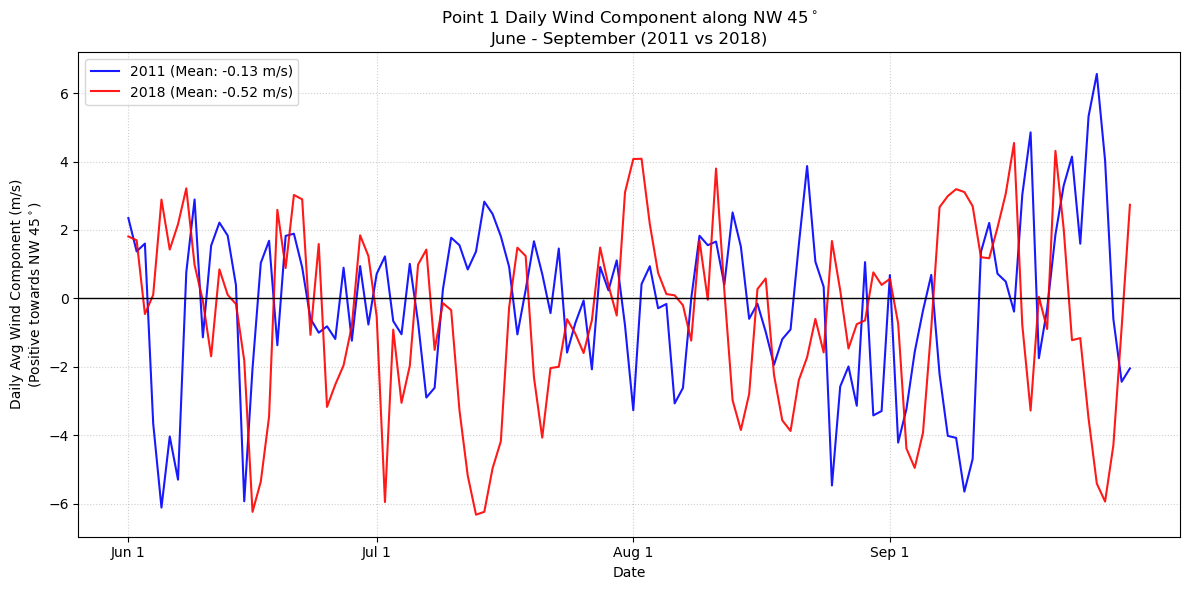


Done.


In [2]:
# Daily Average Wind Speed Along NW 45 

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
import os

# ---------------------------------------------------------
# 1. 配置参数
# ---------------------------------------------------------

# 目标点配置 (Point 1)
TARGET_LAT = 49.0
TARGET_LON = -123.25  # 输入负值
# 大部分海洋模式文件(如GEM/NEMO)经度为0-360。如果你的文件是-180~180，请去掉 "360 +"
TARGET_LON_ADJUSTED = 360 + TARGET_LON 

# 网格半径 (半径10 => 直径21个格点)
GRID_BOX_RADIUS = 10 

# 投影方向: NW 45度 (North West 45 degrees)
# 正北是0度，正西是270度，NW是315度。
# NW 45度通常指正西北方向 (315度)。
PROJECTION_ANGLE_DEG = 315.0 

# 时间范围
MONTHS = [6, 7, 8, 9] # 6月到9月
YEARS = [2011, 2018]

# 路径配置 (请根据实际情况修改)
indir_data = {
    2011: '/results/forcing/atmospheric/GEM2.5/gemlam/',
    2018: '/results/forcing/atmospheric/GEM2.5/operational/',
}
fname_head = {
    2011: 'gemlam_',
    2018: 'ops_',
}
fname_tail = '.nc'
indir_results = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_svg/' # 当前目录下的结果文件夹

if not os.path.exists(indir_results):
    os.makedirs(indir_results)

# 缓存网格索引，避免重复查找
subregion_cache = {}

# ---------------------------------------------------------
# 2. 核心工具函数
# ---------------------------------------------------------

def find_grid_index(nc_file_path, lat_t, lon_t, radius):
    """
    在NC文件中查找离目标经纬度最近的网格点索引 (j, i)
    并返回切片范围。
    """
    print(f"  -> Finding grid indices for Lat={lat_t}, Lon={lon_t} in {os.path.basename(nc_file_path)}...")
    try:
        with nc.Dataset(nc_file_path, 'r') as ds:
            # 兼容不同的变量名
            if 'nav_lat' in ds.variables:
                lats = ds.variables['nav_lat'][:]
                lons = ds.variables['nav_lon'][:]
            elif 'latitude' in ds.variables:
                lats = ds.variables['latitude'][:]
                lons = ds.variables['longitude'][:]
            else:
                raise ValueError("Could not find latitude/longitude variables.")

        # 计算距离平方 (寻找最近点)
        sq_dist = (lons - lon_t)**2 + (lats - lat_t)**2
        j_target, i_target = np.unravel_index(sq_dist.argmin(), sq_dist.shape)
        
        # 定义切片范围
        j_start = max(0, j_target - radius)
        j_end = min(lats.shape[0], j_target + radius + 1)
        i_start = max(0, i_target - radius)
        i_end = min(lats.shape[1], i_target + radius + 1)
        
        print(f"  -> Grid Found: Center({j_target}, {i_target}). Slice: [{j_start}:{j_end}, {i_start}:{i_end}]")
        return j_start, j_end, i_start, i_end
        
    except Exception as e:
        print(f"  [Error] Failed to find grid index: {e}")
        return None, None, None, None

def get_daily_projected_wind(year, month_list, lat_t, lon_t, radius, angle_deg):
    """
    读取指定年份、月份的数据，计算每一天的：
    1. 区域平均
    2. 沿指定方向(NW 45)投影的风速分量
    3. 日平均值
    """
    
    # 预计算角度的 sin 和 cos
    # 数学公式: V_proj = u * sin(theta) + v * cos(theta)
    # 气象风向转换到数学角度通常需要小心，但直接使用投影公式：
    # 如果 0度=北(V+), 90度=东(U+)。
    # 315度 (NW): sin(315) < 0 (West), cos(315) > 0 (North). 
    # U should be negative, V should be positive. Correct.
    angle_rad = np.deg2rad(angle_deg)
    sin_a = np.sin(angle_rad)
    cos_a = np.cos(angle_rad)
    
    days_axis = [] # 存储 "距离6月1日的天数" 用于绘图对齐
    daily_values = []
    
    # 获取该年份的文件前缀和路径
    path = indir_data[year]
    head = fname_head[year]
    
    # 为了确定网格索引，先找这一年的第一个文件试运行
    sample_date = datetime.date(year, 6, 1)
    sample_file = path + head + sample_date.strftime('y%Ym%md%d') + fname_tail
    
    # 如果缓存里没有，就找一次
    cache_key = (year, lat_t, lon_t)
    if cache_key in subregion_cache:
        j_s, j_e, i_s, i_e = subregion_cache[cache_key]
    else:
        # 如果6月1日文件不存在，尝试往后找几天以获取网格信息
        if not os.path.exists(sample_file):
            print(f"  [Warning] {sample_file} not found, trying next day for grid search...")
            sample_file = path + head + datetime.date(year, 6, 2).strftime('y%Ym%md%d') + fname_tail
            
        if os.path.exists(sample_file):
            j_s, j_e, i_s, i_e = find_grid_index(sample_file, lat_t, lon_t, radius)
            subregion_cache[cache_key] = (j_s, j_e, i_s, i_e)
        else:
            print(f"  [Error] No files found to determine grid for {year}.")
            return [], []

    # 开始循环日期
    start_date = datetime.date(year, month_list[0], 1)
    # 简单处理：结束日期设为9月30日
    end_date = datetime.date(year, month_list[-1], 30) 
    
    current_date = start_date
    day_counter = 0 # 从第0天开始 (6月1日)
    
    print(f"Processing {year} from {start_date} to {end_date}...")
    
    while current_date <= end_date:
        fpath = path + head + current_date.strftime('y%Ym%md%d') + fname_tail
        
        val_to_append = np.nan # 默认空值
        
        if os.path.exists(fpath) and j_s is not None:
            try:
                with nc.Dataset(fpath, 'r') as ds:
                    # 读取区域数据 (Time, Y, X)
                    u_data = ds.variables['u_wind'][:, j_s:j_e, i_s:i_e]
                    v_data = ds.variables['v_wind'][:, j_s:j_e, i_s:i_e]
                    
                    # 1. 空间平均 (Spatial Mean) -> 变成 (Time,) 形状
                    # 也就是该区域每一个小时的平均风速
                    u_spatial_avg = np.mean(u_data, axis=(1, 2))
                    v_spatial_avg = np.mean(v_data, axis=(1, 2))
                    
                    # 2. 投影计算 (Project to NW 45)
                    # V_nw45 = U * sin(315) + V * cos(315)
                    wind_proj_hourly = (u_spatial_avg * sin_a) + (v_spatial_avg * cos_a)
                    
                    # 3. 时间平均 (Daily Mean)
                    val_to_append = np.mean(wind_proj_hourly)
                    
            except Exception as e:
                print(f"    Error reading {current_date}: {e}")
        
        days_axis.append(day_counter)
        daily_values.append(val_to_append)
        
        current_date += datetime.timedelta(days=1)
        day_counter += 1
        
    return days_axis, daily_values

# ---------------------------------------------------------
# 3. 绘图函数
# ---------------------------------------------------------
def plot_comparison(data_map, title_suffix):
    """
    绘制对比图
    data_map: {2011: (x, y), 2018: (x, y)}
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = {2011: 'blue', 2018: 'red'}
    
    for year in YEARS:
        days, values = data_map[year]
        # 过滤掉 NaN 用于计算平均值
        valid_values = [v for v in values if not np.isnan(v)]
        mean_val = np.mean(valid_values) if valid_values else 0
        
        ax.plot(days, values, label=f'{year} (Mean: {mean_val:.2f} m/s)', 
                color=colors[year], linewidth=1.5, alpha=0.9)
        # ax.axhline(mean_val, color=colors[year], linestyle='--', alpha=0.5)

    # 设置 X 轴标签 (将天数转换为日期字符串)
    # 生成 tick label
    tick_locs = [0, 30, 61, 92] # 6/1, 7/1, 8/1, 9/1
    tick_labels = ['Jun 1', 'Jul 1', 'Aug 1', 'Sep 1']
    
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel('Date')
    
    ax.set_ylabel('Daily Avg Wind Component (m/s)\n(Positive towards NW 45$^\circ$)')
    ax.set_title(f'Point 1 Daily Wind Component along NW 45$^\circ$\n{title_suffix}')
    
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.axhline(0, color='black', linewidth=1) # 0线
    
    plt.tight_layout()
    save_path = os.path.join(indir_results, 'Point1_NW45_Daily_Wind_Comparison.svg')
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to: {save_path}")
    plt.show()

# ---------------------------------------------------------
# 主程序
# ---------------------------------------------------------
if __name__ == "__main__":
    print("--- Starting Wind Analysis (Point 1, NW 45, Daily) ---")
    
    data_storage = {}
    
    for yr in YEARS:
        print(f"\nProcessing Year: {yr}")
        days, values = get_daily_projected_wind(
            yr, MONTHS, 
            TARGET_LAT, TARGET_LON_ADJUSTED, 
            GRID_BOX_RADIUS, PROJECTION_ANGLE_DEG
        )
        data_storage[yr] = (days, values)
        
    # 绘图
    plot_comparison(data_storage, "June - September (2011 vs 2018)")
    print("\nDone.")


STORM ANALYSIS (Zero-Crossing Calculation)
[2011] Zero crossing found at index 31.65
       -> Time: 2011-07-02 15:36
[2011] Zero crossing found at index 33.51
       -> Time: 2011-07-04 12:12
[2011] Zero crossing found at index 34.59
       -> Time: 2011-07-05 14:13
[2011] Zero crossing found at index 37.91
       -> Time: 2011-07-08 21:48
[2011] Zero crossing found at index 46.47
       -> Time: 2011-07-17 11:14
[2011] Zero crossing found at index 47.81
       -> Time: 2011-07-18 19:23
[2011] Zero crossing found at index 50.63
       -> Time: 2011-07-21 15:01
[2011] Zero crossing found at index 51.23
       -> Time: 2011-07-22 05:26
[2011] Zero crossing found at index 52.48
       -> Time: 2011-07-23 11:31
[2011] Zero crossing found at index 56.69
       -> Time: 2011-07-27 16:36
[2011] Zero crossing found at index 59.59
       -> Time: 2011-07-30 14:04
[2018] Zero crossing found at index 34.67
       -> Time: 2018-07-05 15:59
[2018] Zero crossing found at index 36.49
       -> Time

<>:97: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2539303/2396184480.py:97: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Wind Speed along NW 45$^\circ$ (m/s)')


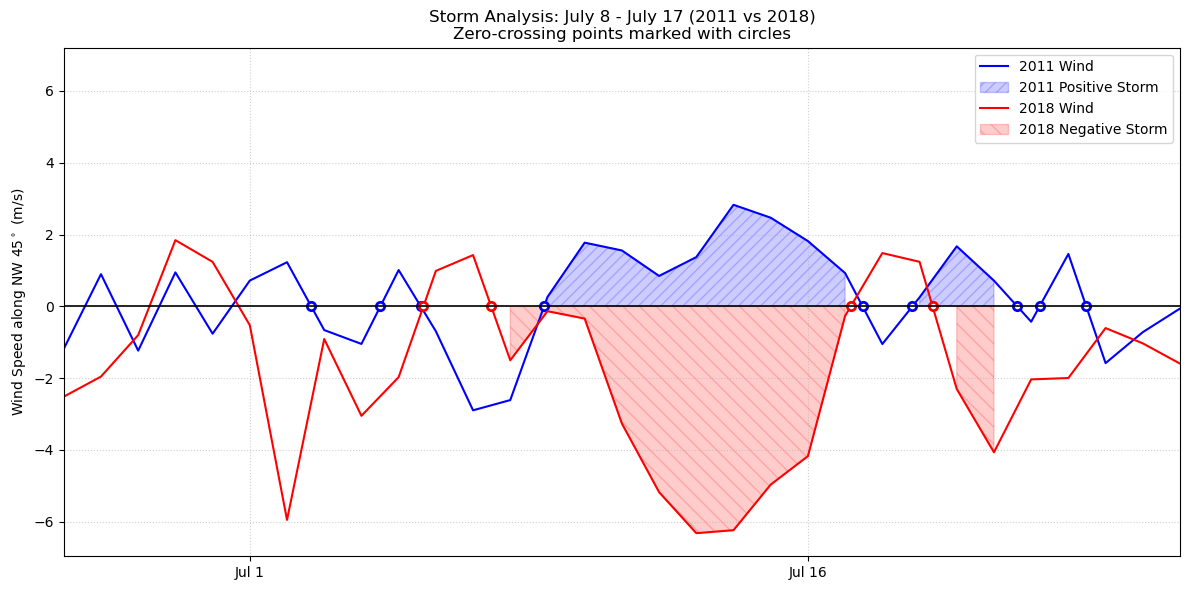

In [3]:
# Storm Demonstration
import matplotlib.dates as mdates

def analyze_and_plot_storms(data_map):
    """
    分析 7.08-7.17 期间的风暴，计算零点并在图中上色。
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 定义绘图颜色
    colors = {2011: 'blue', 2018: 'red'}
    
    # 定义我们关注的时间窗口 (用于搜索交点和绘图聚焦)
    # 7月1日是第30天 (6月30天), 7月31日是第60天
    search_start_idx = 30  # July 1
    search_end_idx = 61    # Aug 1
    
    # 辅助函数：将 day_index (float) 转换为可读时间字符串
    def index_to_str(year, idx):
        base_date = datetime.datetime(year, 6, 1)
        target_date = base_date + datetime.timedelta(days=idx)
        return target_date.strftime("%Y-%m-%d %H:%M")

    print("\n" + "="*50)
    print("STORM ANALYSIS (Zero-Crossing Calculation)")
    print("="*50)

    for year in [2011, 2018]:
        days = np.array(data_map[year][0])
        values = np.array(data_map[year][1])
        
        # 1. 绘制基础曲线
        # 处理 NaN，防止绘图断裂影响观测，这里简单填充或跳过
        mask_valid = ~np.isnan(values)
        ax.plot(days[mask_valid], values[mask_valid], 
                label=f'{year} Wind', color=colors[year], linewidth=1.5)
        
        # 2. 计算与 0 线交点 (Linear Interpolation)
        crossings = []
        
        # 只在 7月份范围内搜索
        for i in range(search_start_idx, search_end_idx):
            if i >= len(values) - 1: break
            
            y1 = values[i]
            y2 = values[i+1]
            
            # 如果y1和y2都不是NaN，且符号相反 (异号相乘 < 0)
            if not np.isnan(y1) and not np.isnan(y2):
                if y1 * y2 < 0: 
                    # 线性插值公式: x = x1 + |y1| / (|y1| + |y2|) * (x2 - x1)
                    # 假设 x2 - x1 = 1 (天)
                    offset = abs(y1) / (abs(y1) + abs(y2))
                    x_zero = days[i] + offset
                    crossings.append(x_zero)
                    
                    # 打印结果
                    print(f"[{year}] Zero crossing found at index {x_zero:.2f}")
                    print(f"       -> Time: {index_to_str(year, x_zero)}")

        # 在图中标记交点
        for cx in crossings:
            ax.plot(cx, 0, 'o', color=colors[year], markersize=6, markerfacecolor='white', markeredgewidth=2)

        # 3. 区域上色 (Highlighting)
        # 关注窗口：大约在 index 37 (7月8日) 到 index 47 (7月18日) 之间
        # 我们可以稍微放宽一点 fill 的范围，让它自动切断
        roi_start = 35 # July 6
        roi_end = 50   # July 21
        
        if year == 2011:
            # 2011年：填涂 0 线以上的部分 (Positive Storm)
            ax.fill_between(days, values, 0, 
                            where=(values > 0) & (days >= roi_start) & (days <= roi_end),
                            color='blue', alpha=0.2, hatch='///', label='2011 Positive Storm')
            
        elif year == 2018:
            # 2018年：填涂 0 线以下的部分 (Negative Storm)
            ax.fill_between(days, values, 0, 
                            where=(values < 0) & (days >= roi_start) & (days <= roi_end),
                            color='red', alpha=0.2, hatch='\\\\', label='2018 Negative Storm')

    # ------------------------------------------------
    # 图表美化
    # ------------------------------------------------
    
    # 设置 X 轴刻度 (6/1, 6/15, 7/1, 7/15, 8/1...)
    tick_positions = [0, 15, 30, 45, 61, 76, 92]
    tick_labels = ['Jun 1', 'Jun 16', 'Jul 1', 'Jul 16', 'Aug 1', 'Aug 16', 'Sep 1']
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    
    # 聚焦到 7 月份
    ax.set_xlim(25, 55) # 从 6月26日 到 7月26日，放大看细节
    
    ax.axhline(0, color='black', linewidth=1.2) # 0风速线
    ax.set_ylabel('Wind Speed along NW 45$^\circ$ (m/s)')
    ax.set_title('Storm Analysis: July 8 - July 17 (2011 vs 2018)\nZero-crossing points marked with circles')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # 保存图片
    save_path = './results_wind_timeseries/Storm_Analysis_Zoomed.png'
    plt.tight_layout()
    # plt.savefig(save_path, dpi=300)
    print("="*50)
    print(f"Plot saved to: {save_path}")
   

# --- 调用方法 ---
# 确保在主程序中 data_storage 已经计算好后调用：
if __name__ == "__main__":
    # ... (前面的代码保持不变，确保 data_storage 已经有了数据) ...
    # 假设 data_storage = {2011: (days, vals), 2018: (days, vals)}
    
    if 'data_storage' in locals():
        analyze_and_plot_storms(data_storage)
    else:
        print("请先运行数据读取部分以生成 data_storage。")

Usually we expect to see the biological response within 1 week after the storm, but in this case, considering the duration of the storm exceeded 10 days, the biological response might be obvious with in 3 days.

<>:204: SyntaxWarning: invalid escape sequence '\c'
<>:204: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2539303/2921354158.py:204: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Daily Avg Wind Component (m/s)\n(Positive towards NW 45$^\circ$)')


--- Starting Wind Analysis with Biological Context ---
Processing 2011...
Processing 2018...
Plot saved to: ./home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_svg/Wind_and_Expected_Response_Time.svg


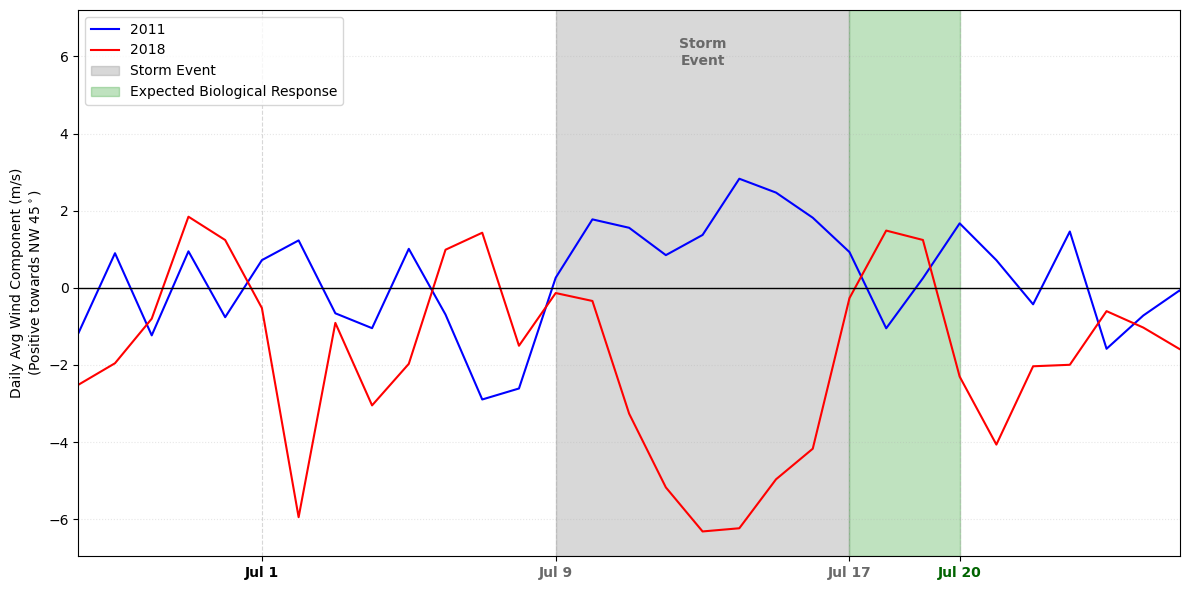


Done.


In [7]:
# Storm Wind Analysis and Duration Visualization

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
import os

# ---------------------------------------------------------
# 1. 配置参数
# ---------------------------------------------------------

# 目标点配置 (Point 1)
TARGET_LAT = 49.0
TARGET_LON = -123.25 
TARGET_LON_ADJUSTED = 360 + TARGET_LON # 你的文件经度如果是0-360格式

# 网格半径 (半径10 => 直径21个格点)
GRID_BOX_RADIUS = 10 

# 投影方向: NW 45度
PROJECTION_ANGLE_DEG = 315.0 

# 时间范围: 6月 - 9月
MONTHS = [6, 7, 8, 9] 
YEARS = [2011, 2018]

# 路径配置 (请确保路径正确)
indir_data = {
    2011: '/results/forcing/atmospheric/GEM2.5/gemlam/',
    2018: '/results/forcing/atmospheric/GEM2.5/operational/',
}
fname_head = {
    2011: 'gemlam_',
    2018: 'ops_',
}
fname_tail = '.nc'
indir_results = './home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_svg/'

if not os.path.exists(indir_results):
    os.makedirs(indir_results)

# 缓存
subregion_cache = {}

# ---------------------------------------------------------
# 2. 核心工具函数 (无需修改)
# ---------------------------------------------------------
def find_grid_index(nc_file_path, lat_t, lon_t, radius):
    # (此处省略打印信息，保持简洁)
    try:
        with nc.Dataset(nc_file_path, 'r') as ds:
            if 'nav_lat' in ds.variables:
                lats = ds.variables['nav_lat'][:]
                lons = ds.variables['nav_lon'][:]
            elif 'latitude' in ds.variables:
                lats = ds.variables['latitude'][:]
                lons = ds.variables['longitude'][:]
            else:
                return None, None, None, None

        sq_dist = (lons - lon_t)**2 + (lats - lat_t)**2
        j_target, i_target = np.unravel_index(sq_dist.argmin(), sq_dist.shape)
        
        j_start = max(0, j_target - radius)
        j_end = min(lats.shape[0], j_target + radius + 1)
        i_start = max(0, i_target - radius)
        i_end = min(lats.shape[1], i_target + radius + 1)
        return j_start, j_end, i_start, i_end
    except:
        return None, None, None, None

def get_daily_projected_wind(year, month_list, lat_t, lon_t, radius, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    sin_a = np.sin(angle_rad)
    cos_a = np.cos(angle_rad)
    
    days_axis = []
    daily_values = []
    
    path = indir_data[year]
    head = fname_head[year]
    
    # 确定网格
    sample_file = path + head + datetime.date(year, 6, 1).strftime('y%Ym%md%d') + fname_tail
    cache_key = (year, lat_t, lon_t)
    
    if cache_key in subregion_cache:
        j_s, j_e, i_s, i_e = subregion_cache[cache_key]
    else:
        if not os.path.exists(sample_file):
             sample_file = path + head + datetime.date(year, 6, 2).strftime('y%Ym%md%d') + fname_tail
        if os.path.exists(sample_file):
            j_s, j_e, i_s, i_e = find_grid_index(sample_file, lat_t, lon_t, radius)
            subregion_cache[cache_key] = (j_s, j_e, i_s, i_e)
        else:
            return [], []

    start_date = datetime.date(year, month_list[0], 1)
    end_date = datetime.date(year, month_list[-1], 30)
    current_date = start_date
    day_counter = 0 
    
    print(f"Processing {year}...")
    while current_date <= end_date:
        fpath = path + head + current_date.strftime('y%Ym%md%d') + fname_tail
        val_to_append = np.nan
        if os.path.exists(fpath) and j_s is not None:
            try:
                with nc.Dataset(fpath, 'r') as ds:
                    u_data = ds.variables['u_wind'][:, j_s:j_e, i_s:i_e]
                    v_data = ds.variables['v_wind'][:, j_s:j_e, i_s:i_e]
                    u_spatial = np.mean(u_data, axis=(1, 2))
                    v_spatial = np.mean(v_data, axis=(1, 2))
                    wind_proj = (u_spatial * sin_a) + (v_spatial * cos_a)
                    val_to_append = np.mean(wind_proj)
            except: pass
        
        days_axis.append(day_counter)
        daily_values.append(val_to_append)
        current_date += datetime.timedelta(days=1)
        day_counter += 1
        
    return days_axis, daily_values

# ---------------------------------------------------------
# 3. 绘图函数 (包含风暴区 + 生物响应区)
# ---------------------------------------------------------
def plot_storm_and_response(data_map, title_suffix):
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {2011: 'blue', 2018: 'red'}
    
    # 1. 绘制曲线
    for year in YEARS:
        days, values = data_map[year]
        ax.plot(days, values, label=f'{year}', color=colors[year], linewidth=1.5)

    # -------------------------------------------------------
    # 区域定义
    # -------------------------------------------------------
    # 6月1日=0, 7月1日=30
    # 风暴: July 9 (38) -> July 17 (46)
    storm_start = 38
    storm_end = 46
    
    # 生物响应: 紧接风暴后3天
    # July 17 (46) -> July 20 (49)
    response_start = storm_end
    response_end = storm_end + 3 
    
    # 2. 绘制风暴区域 (灰色)
    ax.axvspan(storm_start, storm_end, color='grey', alpha=0.3, label='Storm Event')
    
    # 3. 绘制生物响应区域 (绿色)
    ax.axvspan(response_start, response_end, color='tab:green', alpha=0.3, label='Expected Biological Response')
    
    # -------------------------------------------------------
    # 文字标注
    # -------------------------------------------------------
    y_limits = ax.get_ylim()
    # 文字高度：略低于图表顶端
    text_y = y_limits[1] - (y_limits[1] - y_limits[0]) * 0.05 
    
    # 风暴文字
    ax.text((storm_start + storm_end)/2, text_y, 'Storm\nEvent', 
            ha='center', va='top', fontsize=10, fontweight='bold', color='dimgrey')
    
    # -------------------------------------------------------
    # 4. 重点修改：自定义 X 轴刻度 (Exact Dates)
    # -------------------------------------------------------
    
    # 我们把标准的月首日和我们的关键日混合在一起
    # 注意：Jul 17 和 Jul 20 离得很近，为了防止重叠，我们可以让它们稍微错开，
    # 或者依赖 Matplotlib 的 rotation。
    
    major_ticks = [30, 38, 46, 49] # Jul 1, Jul 9, Jul 17, Jul 20
    major_labels = ['Jul 1', 'Jul 9', 'Jul 17', 'Jul 20']
    
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_labels, rotation=0, fontsize=10, fontweight='bold')
    
    # 5. 给坐标轴标签上色 (Coloring the Tick Labels)
    # 获取刚刚设置的标签对象，逐个修改颜色
    xtick_labels = ax.get_xticklabels()
    for label in xtick_labels:
        txt = label.get_text()
        if txt == 'Jul 9' or txt == 'Jul 17':
            label.set_color('dimgrey')  # 对应风暴颜色
        elif txt == 'Jul 20':
            label.set_color('darkgreen') # 对应生物响应颜色
        elif txt == 'Jul 1':
            label.set_color('black')     # 普通日期

    # 6. 设置显示范围 (Zoom In)
    # 为了让 Jul 17 和 Jul 20 不挤在一起，我们只看 6月25日(25) 到 7月25日(55)
    ax.set_xlim(25, 55)
    
    # 辅助网格：只在关键刻度上画竖线
    ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5)
    ax.grid(True, axis='y', linestyle=':', alpha=0.3)
    
    ax.axhline(0, color='black', linewidth=1)
    
    ax.set_ylabel('Daily Avg Wind Component (m/s)\n(Positive towards NW 45$^\circ$)')
    # ax.set_title(f'Point 1 Wind Analysis: Storm & Biological Response Timeline\n{title_suffix}')
    
    ax.legend(loc='upper left') # 挪到左上角防止挡住右边的字
    
    plt.tight_layout()

    
    save_path = os.path.join(indir_results, 'Wind_and_Expected_Response_Time.svg')
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to: {save_path}")
    plt.show()

# ---------------------------------------------------------
# 主程序
# ---------------------------------------------------------
if __name__ == "__main__":
    print("--- Starting Wind Analysis with Biological Context ---")
    
    data_storage = {}
    
    for yr in YEARS:
        days, values = get_daily_projected_wind(
            yr, MONTHS, 
            TARGET_LAT, TARGET_LON_ADJUSTED, 
            GRID_BOX_RADIUS, PROJECTION_ANGLE_DEG
        )
        data_storage[yr] = (days, values)
        
    plot_storm_and_response(data_storage, "Summer 2011 vs 2018")
    print("\nDone.")

To investigate the distinct meteorological forcing and potential biological responses during summer, we focused on a specific window from July 9 to July 20. This period was selected to capture a significant divergence in wind patterns between the two study years.

As shown in Figure, the period from July 9 to July 17 (highlighted in grey) represents a prolonged storm event where the wind regimes were diametrically opposed: 2011 exhibited consistent positive wind components (directed towards NW 45°), whereas 2018 was characterized by strong negative anomalies (directed towards SE). The analysis window was extended to include the post-storm phase from July 17 to July 20 (highlighted in green). This 'relaxation window' was included to account for the time lag typically required for water column stratification to re-establish and for the subsequent biological response (e.g., diatom blooms) to occur.

<>:189: SyntaxWarning: invalid escape sequence '\c'
<>:189: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2840982/2359894128.py:189: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Daily Avg Wind Component (m/s)\n(Positive towards NW 45$^\circ$)')


--- Starting Clean Wind Analysis ---
Processing 2011...
Processing 2018...
Plot saved to: ./home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_svg/Wind_Storm_Clean.svg


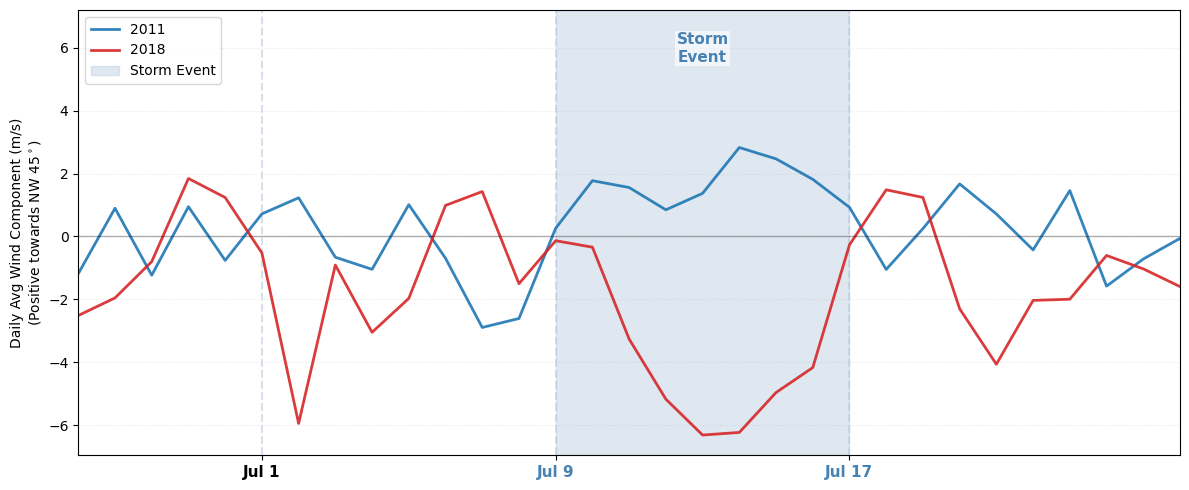


Done.


In [2]:
# Storm Wind Analysis and Duration Visualization (Clean Version)

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
import os

# ---------------------------------------------------------
# 1. 配置参数
# ---------------------------------------------------------

# 目标点配置 (Point 1)
TARGET_LAT = 49.0
TARGET_LON = -123.25 
TARGET_LON_ADJUSTED = 360 + TARGET_LON 

# 网格半径
GRID_BOX_RADIUS = 10 

# 投影方向: NW 45度
PROJECTION_ANGLE_DEG = 315.0 

# 时间范围
MONTHS = [6, 7, 8, 9] 
YEARS = [2011, 2018]

# 路径配置
indir_data = {
    2011: '/results/forcing/atmospheric/GEM2.5/gemlam/',
    2018: '/results/forcing/atmospheric/GEM2.5/operational/',
}
fname_head = {
    2011: 'gemlam_',
    2018: 'ops_',
}
fname_tail = '.nc'
indir_results = './home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_svg/'

if not os.path.exists(indir_results):
    os.makedirs(indir_results)

# 缓存
subregion_cache = {}

# ---------------------------------------------------------
# 2. 核心工具函数 (保持不变)
# ---------------------------------------------------------
def find_grid_index(nc_file_path, lat_t, lon_t, radius):
    try:
        with nc.Dataset(nc_file_path, 'r') as ds:
            if 'nav_lat' in ds.variables:
                lats = ds.variables['nav_lat'][:]
                lons = ds.variables['nav_lon'][:]
            elif 'latitude' in ds.variables:
                lats = ds.variables['latitude'][:]
                lons = ds.variables['longitude'][:]
            else:
                return None, None, None, None

        sq_dist = (lons - lon_t)**2 + (lats - lat_t)**2
        j_target, i_target = np.unravel_index(sq_dist.argmin(), sq_dist.shape)
        
        j_start = max(0, j_target - radius)
        j_end = min(lats.shape[0], j_target + radius + 1)
        i_start = max(0, i_target - radius)
        i_end = min(lats.shape[1], i_target + radius + 1)
        return j_start, j_end, i_start, i_end
    except:
        return None, None, None, None

def get_daily_projected_wind(year, month_list, lat_t, lon_t, radius, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    sin_a = np.sin(angle_rad)
    cos_a = np.cos(angle_rad)
    
    days_axis = []
    daily_values = []
    
    path = indir_data[year]
    head = fname_head[year]
    
    # 确定网格 (简单缓存逻辑)
    sample_file = path + head + datetime.date(year, 6, 1).strftime('y%Ym%md%d') + fname_tail
    cache_key = (year, lat_t, lon_t)
    
    if cache_key in subregion_cache:
        j_s, j_e, i_s, i_e = subregion_cache[cache_key]
    else:
        if not os.path.exists(sample_file):
             sample_file = path + head + datetime.date(year, 6, 2).strftime('y%Ym%md%d') + fname_tail
        if os.path.exists(sample_file):
            j_s, j_e, i_s, i_e = find_grid_index(sample_file, lat_t, lon_t, radius)
            subregion_cache[cache_key] = (j_s, j_e, i_s, i_e)
        else:
            return [], []

    start_date = datetime.date(year, month_list[0], 1)
    end_date = datetime.date(year, month_list[-1], 30)
    current_date = start_date
    day_counter = 0 
    
    print(f"Processing {year}...")
    while current_date <= end_date:
        fpath = path + head + current_date.strftime('y%Ym%md%d') + fname_tail
        val_to_append = np.nan
        if os.path.exists(fpath) and j_s is not None:
            try:
                with nc.Dataset(fpath, 'r') as ds:
                    u_data = ds.variables['u_wind'][:, j_s:j_e, i_s:i_e]
                    v_data = ds.variables['v_wind'][:, j_s:j_e, i_s:i_e]
                    u_spatial = np.mean(u_data, axis=(1, 2))
                    v_spatial = np.mean(v_data, axis=(1, 2))
                    wind_proj = (u_spatial * sin_a) + (v_spatial * cos_a)
                    val_to_append = np.mean(wind_proj)
            except: pass
        
        days_axis.append(day_counter)
        daily_values.append(val_to_append)
        current_date += datetime.timedelta(days=1)
        day_counter += 1
        
    return days_axis, daily_values

# ---------------------------------------------------------
# 3. 绘图函数 (Clean Version)
# ---------------------------------------------------------
def plot_storm_clean(data_map, title_suffix):
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # 颜色定义
    colors_line = {2011: 'tab:blue', 2018: 'tab:red'}
    color_storm = 'lightsteelblue'  # 统一用这个淡钢蓝
    
    # 1. 绘制曲线
    for year in YEARS:
        days, values = data_map[year]
        ax.plot(days, values, label=f'{year}', color=colors_line[year], linewidth=2, alpha=0.9)

    # -------------------------------------------------------
    # 区域定义
    # -------------------------------------------------------
    # 6月1日=0, 7月1日=30
    # 风暴: July 9 (38) -> July 17 (46)
    storm_start = 38
    storm_end = 46
    
    # 2. 绘制风暴区域 (单色背景)
    ax.axvspan(storm_start, storm_end, color=color_storm, alpha=0.4, label='Storm Event')
    
    # 3. 绘制文字 (仅风暴)
    y_limits = ax.get_ylim()
    text_y = y_limits[1] - (y_limits[1] - y_limits[0]) * 0.05 
    
    ax.text((storm_start + storm_end)/2, text_y, 'Storm\nEvent', 
            ha='center', va='top', fontsize=11, fontweight='bold', 
            color='steelblue',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))
    
    # -------------------------------------------------------
    # 4. 自定义 X 轴刻度 (去掉了生物响应的 Jul 20)
    # -------------------------------------------------------
    
    # 刻度: Jul 1, Jul 9, Jul 17
    major_ticks = [30, 38, 46] 
    major_labels = ['Jul 1', 'Jul 9', 'Jul 17']
    
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_labels, rotation=0, fontsize=11, fontweight='bold')
    
    # 5. 刻度上色
    xtick_labels = ax.get_xticklabels()
    for label in xtick_labels:
        txt = label.get_text()
        if txt == 'Jul 9' or txt == 'Jul 17':
            label.set_color('steelblue')  # 风暴色
        elif txt == 'Jul 1':
            label.set_color('black')     

    # 6. 设置显示范围 (Zoom In)
    # 范围: 6月25日(25) -> 7月25日(55)
    ax.set_xlim(25, 55)
    
    # 辅助网格
    ax.grid(True, which='major', axis='x', linestyle='--', color=color_storm, linewidth=1.5, alpha=0.5)
    ax.grid(True, axis='y', linestyle=':', alpha=0.3)
    ax.axhline(0, color='black', linewidth=1, alpha=0.3)
    
    ax.set_ylabel('Daily Avg Wind Component (m/s)\n(Positive towards NW 45$^\circ$)')
    #ax.set_title(f'Wind Analysis: Storm Duration', fontsize=13)
    
    ax.legend(loc='upper left', frameon=True) 
    
    plt.tight_layout()
    
    save_path = os.path.join(indir_results, 'Wind_Storm_Clean.svg')
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to: {save_path}")
    plt.show()

# ---------------------------------------------------------
# 主程序
# ---------------------------------------------------------
if __name__ == "__main__":
    print("--- Starting Clean Wind Analysis ---")
    
    data_storage = {}
    
    for yr in YEARS:
        days, values = get_daily_projected_wind(
            yr, MONTHS, 
            TARGET_LAT, TARGET_LON_ADJUSTED, 
            GRID_BOX_RADIUS, PROJECTION_ANGLE_DEG
        )
        data_storage[yr] = (days, values)
        
    plot_storm_clean(data_storage, "Summer 2011 vs 2018")
    print("\nDone.")